# Pipeline

In [275]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.spatial import ConvexHull, Delaunay
from tqdm.notebook import tqdm

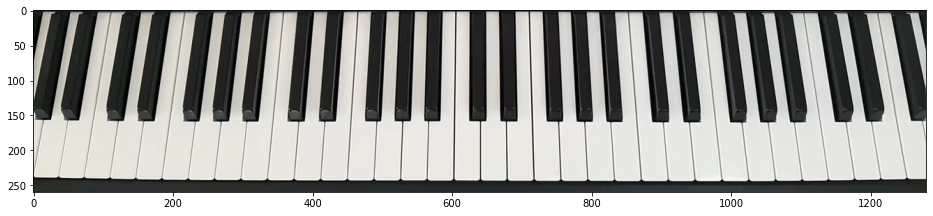

In [276]:
image = cv2.imread('pictures/blank_piano/piano2.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()

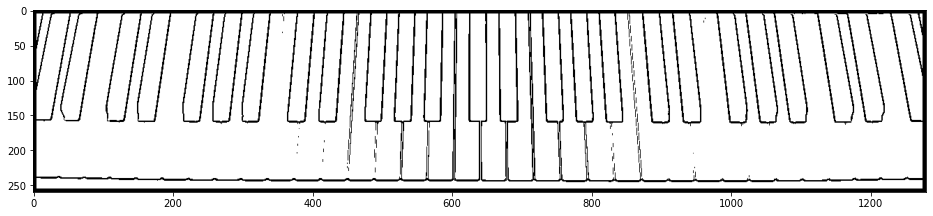

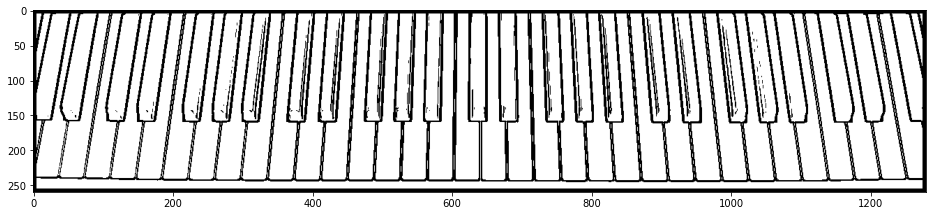

In [277]:
def get_sobel(image, kernel_size=5, threshold=5000, kx=1, ky=1, crop=5, show=False):
    """Parameters:
    image: input image (RGB or grayscale)
    kernel_size: size of the Sobel kernel
    threshold: threshold for the Sobel filter
    kx: when kx is high, the filter is more sensitive to vertical edges
    ky: when ky is high, the filter is more sensitive to horizontal edges
    crop: borders to paint in black(list or int)
    """
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        pass
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel = np.sqrt(kx*sobelx**2 + ky*sobely**2) # Sobel filter with kx and ky weights
    sobel[sobel <= threshold] = 255 # thresholding, we want edges to be black for the next steps
    sobel[sobel > threshold] = 0
    # paint in black the borders
    if type(crop) == int:
        sobel[:crop, :] = 0
        sobel[-crop:, :] = 0
        sobel[:, :crop] = 0
        sobel[:, -crop:] = 0
    else:
        sobel[:crop[0], :] = 0
        sobel[-crop[1]:, :] = 0
        sobel[:, :crop[2]] = 0
        sobel[:, -crop[3]:] = 0
    sobel = sobel.astype(np.uint8)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(sobel, cmap='gray')
        plt.show()
    return sobel

_ = get_sobel(image, show=True)
_ = get_sobel(image, kx=10, show=True)

Number of connected components: 59


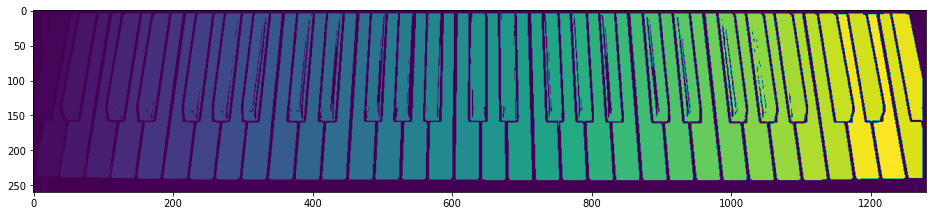

In [278]:
def get_connected_components(image, min_area=800, max_width=100, show=False):
    """Parameters:
    image: input grayscale image (uint8)
    min_area: minimum area of the connected components
    max_width: maximum width of the connected components
    """
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    # stats is a matrix with the following columns:
    # [left, top, width, height, area]
    # we want to keep only the connected components with area > min_area
    # left, top, width, height are the coordinates of the bounding box of the connected component
    # we want to keep only the connected components width < 100
    for i in range(1, n_labels):
        if stats[i, 4] < min_area or stats[i, 2] > max_width:
            labels[labels == i] = 0
    labels[labels > 0] = 255
    labels = labels.astype(np.uint8)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels)
    print('Number of connected components:', n_labels-1) # we don't count the background
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(labels)
        plt.show()
    return n_labels, labels, stats, centroids

n_labels, labels, stats, centroids = get_connected_components(get_sobel(image, kx=10), show=True)

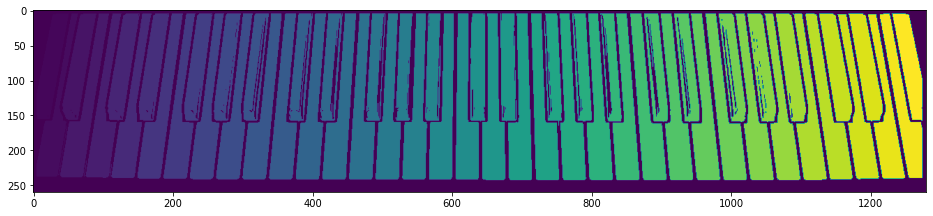

In [279]:
def reassign_labels(labels, stats, centroids, show=False):
    """Reassign the labels of the connected components so that they are ordered from left to right.
    Parameters:
    labels: labels of the connected components
    stats: stats of the connected components
    centroids: centroids of the connected components
    """
    # we want to reassign the labels, stats and centroids so that they are ordered from left to right
    # we use the centroids to do that
    # we sort the centroids by their x coordinate
    c = centroids[1:, :] # we don't want to sort the background
    c = c[c[:, 0].argsort()]
    # we reassign the labels, stats and centroids
    new_labels = np.zeros_like(labels)
    new_stats = np.zeros_like(stats)
    new_centroids = np.zeros_like(centroids)
    for i in range(1, len(c)+1):
        index = np.where((centroids == c[i-1]).all(axis=1))[0][0]
        new_labels[labels == index] = i
        new_stats[i] = stats[index]
        new_centroids[i] = centroids[index]
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_labels)
        plt.show()
    return new_labels, new_stats, new_centroids

labels, stats, centroids = reassign_labels(labels, stats, centroids, show=True)

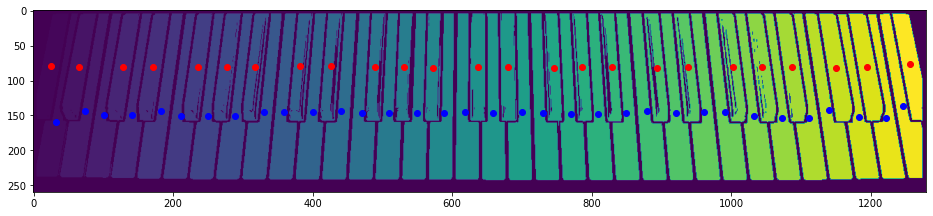

In [280]:
def get_black_keys(labels, centroids, show=False):
    """Parameters:
    labels: output of cv2.connectedComponentsWithStats
    centroids: output of cv2.connectedComponentsWithStats
    """
    # find largest gap between centroids
    c = centroids[1:]
    c = c[c[:,1].argsort()][:,1]
    max_gap = [0,0]
    for i in range(len(c)-1):
        if c[i+1] - c[i] > max_gap[1]-max_gap[0]:
            max_gap = [c[i], c[i+1]]
    separator = (max_gap[0] + max_gap[1]) / 2
    # centroids of black keys are higher than the centroids of white keys
    black_keys = []
    white_keys = []
    for i in range(1, len(centroids)):
        if centroids[i,1] < separator:
            black_keys.append(i)
        else:
            white_keys.append(i)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(labels) #, cmap='jet')
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c='r')
        plt.scatter(centroids[white_keys,0], centroids[white_keys,1], c='b')
        plt.show()
    return black_keys, white_keys

black_keys, white_keys = get_black_keys(labels, centroids, show=True)

  0%|          | 0/25 [00:00<?, ?it/s]

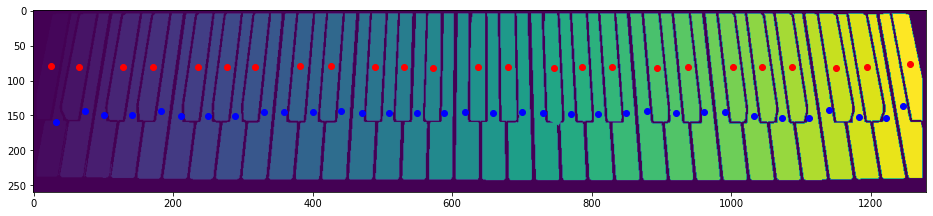

In [281]:
# get the convex hull of each black key
def get_convex_hull(labels, key_number):
    # get the coordinates of the pixels of the key
    X,Y = np.where(labels == key_number)
    # get the convex hull
    hull = ConvexHull(np.array([X,Y]).T)
    return hull

# check if a point is inside a convex hull
def is_inside_hull(hull, point):
    # get the vertices of the convex hull
    vertices = hull.points[hull.vertices]
    # get the Delaunay triangulation of the vertices
    tri = Delaunay(vertices)
    # check if the point is inside the convex hull
    return tri.find_simplex(point) >= 0

# fill the convex hull of a black key with white
def fill_hull(labels, key_number):
    new_labels = labels.copy()
    # get the convex hull
    hull = get_convex_hull(new_labels, key_number)
    # fill the convex hull with white
    # get xmin, xmax, ymin, ymax of the convex hull to limit the search
    xmin = np.min(hull.points[hull.vertices,0])
    xmax = np.max(hull.points[hull.vertices,0])
    ymin = np.min(hull.points[hull.vertices,1])
    ymax = np.max(hull.points[hull.vertices,1])
    for x in range(int(xmin), int(xmax)+1):
        for y in range(int(ymin), int(ymax)+1):
            if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                new_labels[x,y] = key_number
    return new_labels

# fill the convex hull of all black keys with white
def fill_all_hulls(labels, centroids, black_keys, white_keys, show=False):
    new_labels = labels.copy()
    for key in tqdm(black_keys):
        new_labels = fill_hull(new_labels, key)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_labels)
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c='r')
        plt.scatter(centroids[white_keys,0], centroids[white_keys,1], c='b')
        plt.show()
    return new_labels

# fill the convex hull of all black keys with white
labels = fill_all_hulls(labels, centroids, black_keys, white_keys, show=True)



In [282]:
def highlight_key(labels, key_number):
    new_labels = np.zeros_like(labels)
    new_labels[labels == key_number] = 255
    new_labels[labels == 0] = 0
    new_labels[(labels != key_number) & (labels != 0)] = 100
    return new_labels

In [283]:
def show_key(key_number,):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, n_labels-1))

interactive(children=(IntSlider(value=30, description='key_number', max=59, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [284]:
def highlight_key_from_image(image, labels, key_number):
    new_image = image.copy()
    new_image[labels == key_number] = [0,255,0]
    return new_image

def show_key_from_image(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key_from_image(image, labels, key_number))
    plt.show()

interact(show_key_from_image, key_number=(1, n_labels-1))

interactive(children=(IntSlider(value=30, description='key_number', max=59, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>

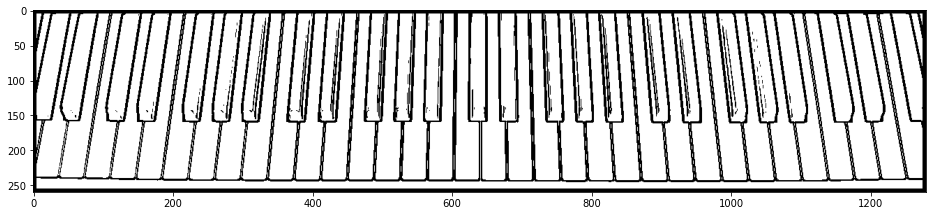

Number of connected components: 59


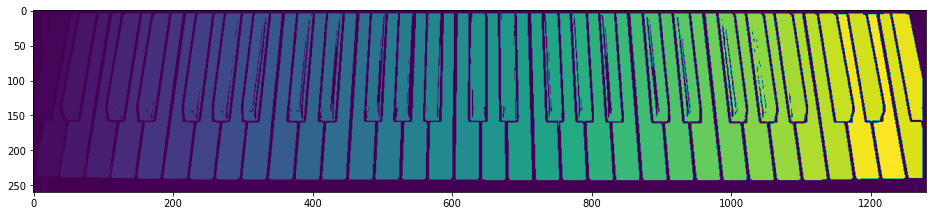

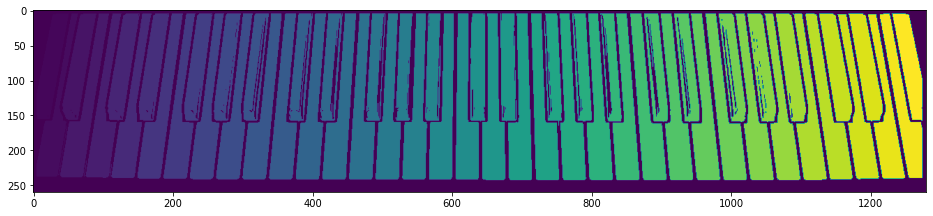

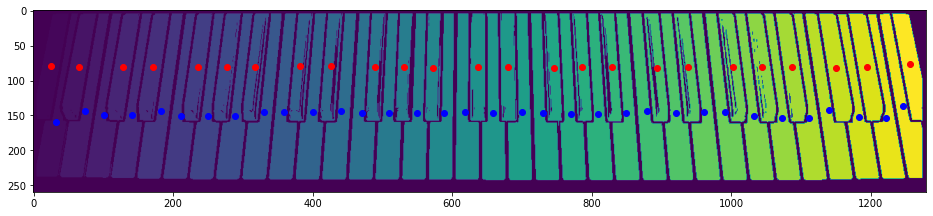

  0%|          | 0/25 [00:00<?, ?it/s]

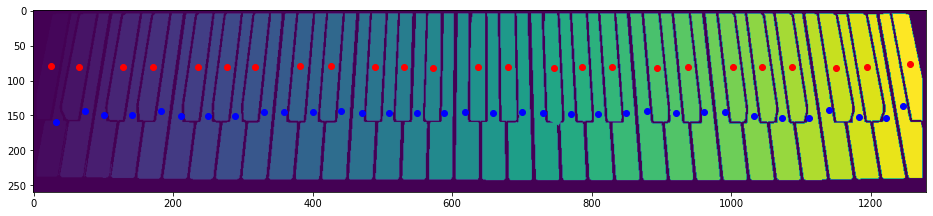

In [285]:
def pipeline(image, with_hull=False, show=False, kernel_size=5, threshold=5000, kx=10, ky=1, crop=5, min_area=800, max_width=100):
    if type(show) == bool:
        show = [show]*5
    sobel = get_sobel(image, kernel_size=kernel_size, threshold=threshold, kx=kx, ky=ky, crop=crop, show=show[0])
    n_labels, labels, stats, centroids = get_connected_components(sobel, min_area=min_area, max_width=max_width, show=show[1])
    labels, stats, centroids = reassign_labels(labels, stats, centroids, show=show[2])
    black_keys, white_keys = get_black_keys(labels, centroids, show=show[3])
    if with_hull:
        labels = fill_all_hulls(labels, centroids, black_keys, white_keys, show=show[4])
    return labels, black_keys, white_keys, n_labels, stats, centroids, sobel

labels, black_keys, white_keys, n_labels, stats, centroids, sobel = pipeline(image, with_hull=True, show=True)

In [286]:
#def show_pipeline(threshold,kx,min_area,max_width):
#    _ = pipeline(image, threshold=threshold, kx=kx, crop=[10,1,2,2], min_area=min_area, max_width=max_width, show=[1,1,1,1,0])
#interact(show_pipeline, threshold=(1,10000), kx=(1,50), min_area=(0,10000), max_width=(100,200))

# Test

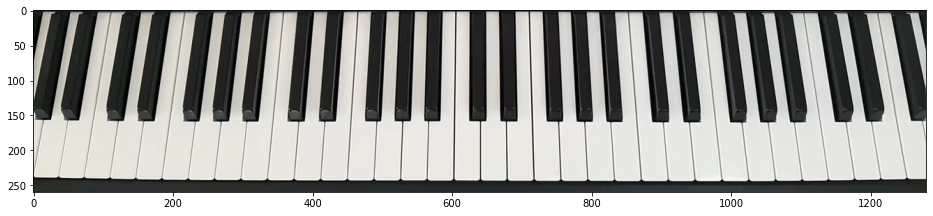

Number of connected components: 59


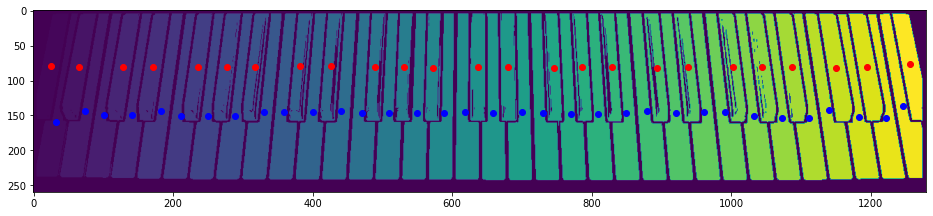

  0%|          | 0/25 [00:00<?, ?it/s]

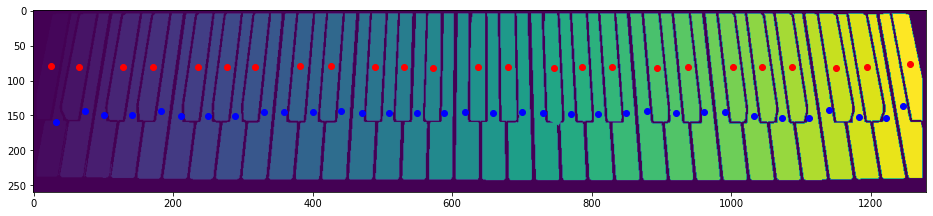

In [287]:
image = cv2.imread('pictures/blank_piano/piano2.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()
labels, black_keys, white_keys, n_labels, stats, centroids, sobel = pipeline(image, with_hull=True, show=[0,0,0,1,1])

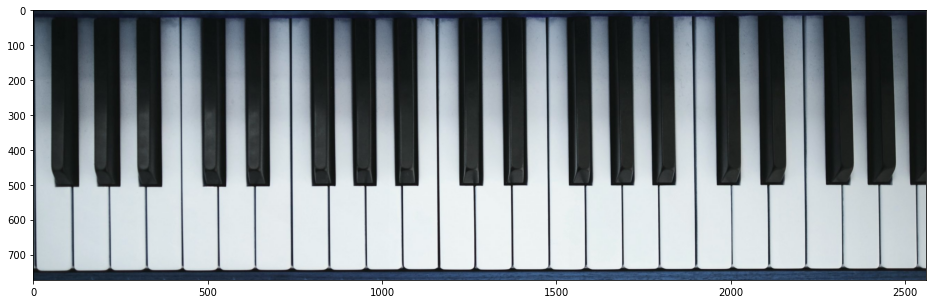

Number of connected components: 42


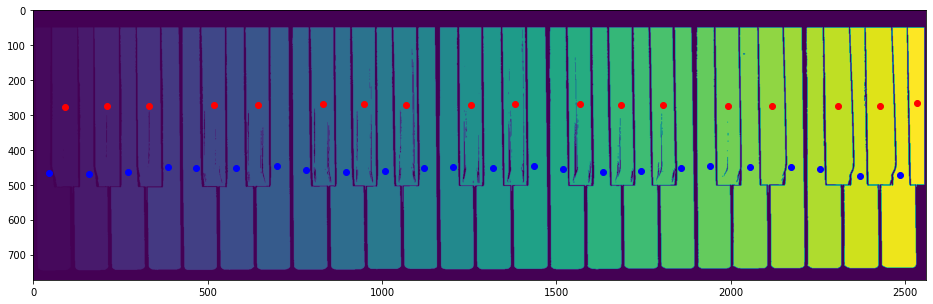

  0%|          | 0/18 [00:00<?, ?it/s]

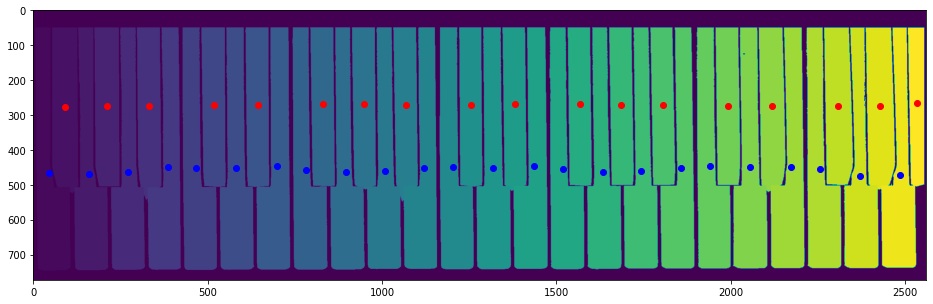

In [288]:
image = cv2.imread('pictures/blank_piano/piano3.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()
_ = pipeline(image, with_hull=True, kx=30, crop=[50,5,5,5], min_area=5000, max_width=200, show=[0,0,0,1,1])

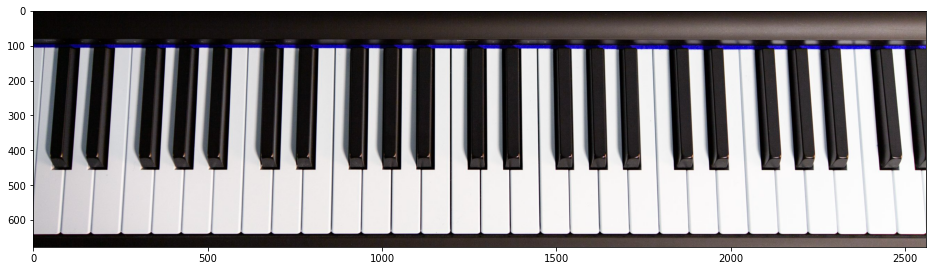

Number of connected components: 52


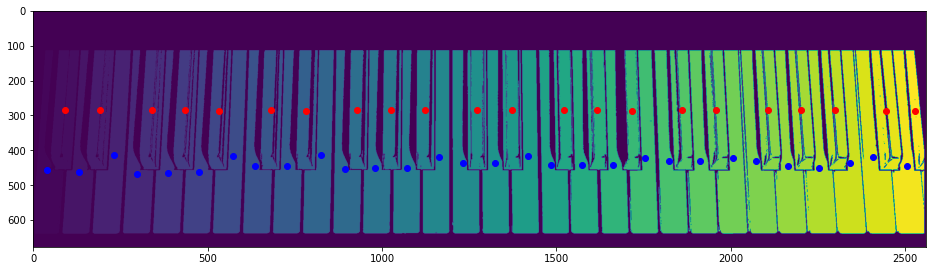

  0%|          | 0/22 [00:00<?, ?it/s]

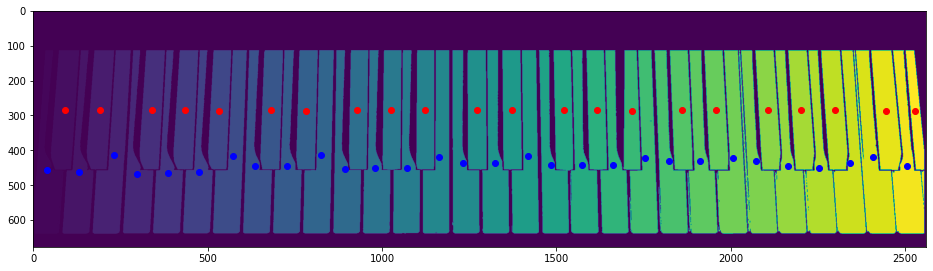

In [289]:
image = cv2.imread('pictures/blank_piano/piano4.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()
labels, black_keys, white_keys, n_labels, stats, centroids, sobel = pipeline(image, with_hull=True, kx=20, crop=[115,5,5,5], min_area=5000, max_width=200, show=[0,0,0,1,1])

In [290]:
interact(show_key_from_image, key_number=(1, n_labels-1))

interactive(children=(IntSlider(value=26, description='key_number', max=52, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>

# Name notes

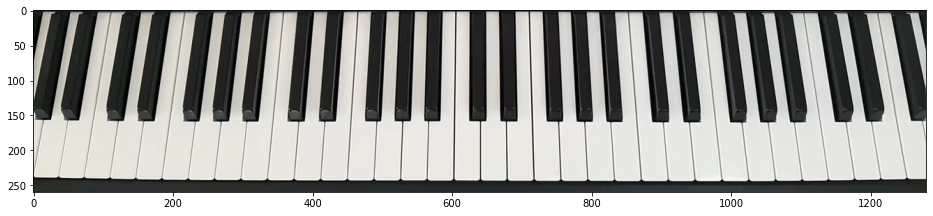

Number of connected components: 59


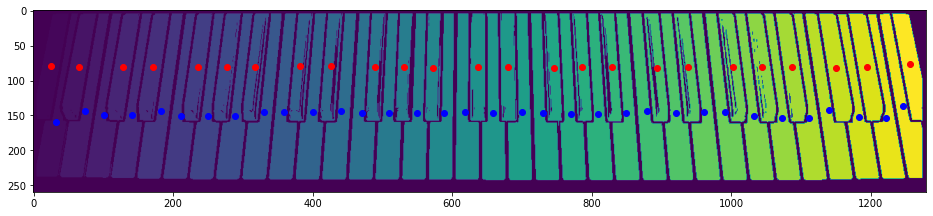

In [349]:
image = cv2.imread('pictures/blank_piano/piano2.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()
labels, black_keys, white_keys, n_labels, stats, centroids, sobel = pipeline(image, with_hull=False, show=[0,0,0,1,1])

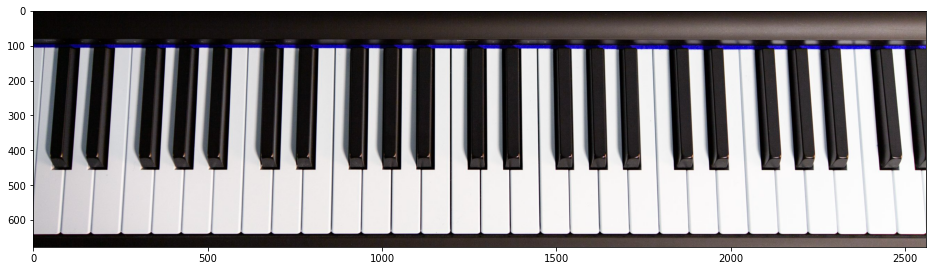

Number of connected components: 51


interactive(children=(IntSlider(value=26, description='key_number', max=51, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>

In [346]:
image = cv2.imread('pictures/blank_piano/piano4.png')
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.show()
labels, black_keys, white_keys, n_labels, stats, centroids, sobel = pipeline(image, with_hull=False, kx=20, crop=[115,5,5,5], min_area=10000, max_width=200, show=False)
interact(show_key_from_image, key_number=(1, n_labels-1))

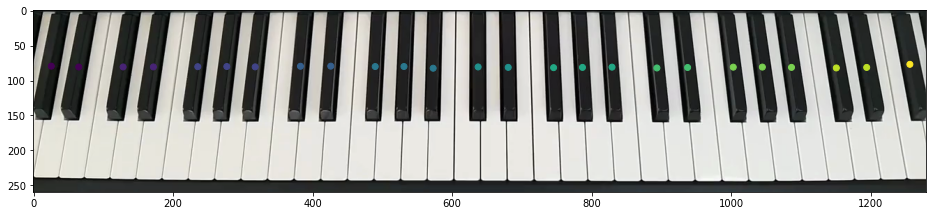

In [350]:
def groups_black_key(centroids, black_keys, image, show = False):
    """Return the groups of black keys (groups of 3 or 2)"""
    c = centroids[black_keys,0]
    c = np.diff(c)
    max_gap = [0,0]
    for i in range(len(c)-1):
        if c[i+1] - c[i] > max_gap[1]-max_gap[0]:
            max_gap = [c[i], c[i+1]]
    separator = (max_gap[0] + max_gap[1]) / 2
    group = [0]
    for i in range(1,len(black_keys)):
        if centroids[black_keys[i],0] - centroids[black_keys[i-1],0] < separator:
            group.append(group[-1])
        else:
            group.append(group[-1]+1)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c=group)
        plt.show()
    return group

group = groups_black_key(centroids, black_keys, image, True)

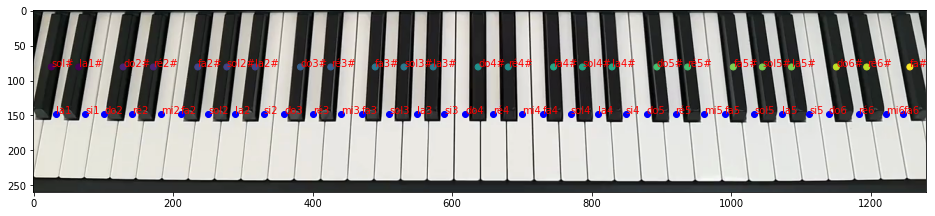

In [351]:
def get_notes(centroids, black_keys, white_keys, group, image, show=False):
    """Return the notes of the piano (dict)"""
    notes = {}
    list_notes = ['do', 'ré', 'mi', 'fa', 'sol', 'la', 'si']
    # once we have found a group of 3 black keys, we can find the notes
    for i in range(len(group)):
        if group[i] == group[i+1] == group[i+2]:
            notes[black_keys[i]] = list_notes[3]+'#'
            start = black_keys[i]
            break
    index_notes = 3
    # now we can find the other notes by looking at adjacent keys etc
    for i in range(start+1, max(max(black_keys), max(white_keys))+1):
        if i in black_keys:
            notes[i] = list_notes[index_notes]+'#'
        else:
            index_notes = (index_notes + 1) % 7
            notes[i] = list_notes[index_notes]
    index_notes = 3
    for i in range(start-1, min(min(black_keys), min(white_keys))-1, -1):
        if i in black_keys:
            notes[i] = list_notes[index_notes]+'#'
        else:
            notes[i] = list_notes[index_notes]
            index_notes = (index_notes - 1) % 7
    # get the octave
    middle = (centroids[0,0] + centroids[-1,0]) / 2
    do4 = min(white_keys, key=lambda x:abs(centroids[x,0]-middle)) # do closest to the middle of the image
    notes[do4] = notes[do4] + '4'
    octave = 4
    for i in range(do4+1, max(white_keys)+1):
        if notes[i] == 'la':
            octave += 1
        if i in white_keys:
            notes[i] = notes[i] + str(octave)
        else:
            notes[i] = notes[i][:-1] + str(octave) + "#"
    octave = 4
    for i in range(do4-1, min(white_keys)-1, -1):
        if notes[i] == 'si':
            octave -= 1
        if i in white_keys:
            notes[i] = notes[i] + str(octave)
        else:
            notes[i] = notes[i][:-1] + str(octave) + "#"

    if show:
        y_black = np.mean(centroids[black_keys,1])
        y_white = np.mean(centroids[white_keys,1])
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.scatter(centroids[black_keys,0], y_black*np.ones(len(black_keys)), c=group)
        plt.scatter(centroids[white_keys,0], y_white*np.ones(len(white_keys)), c='b')
        for key in notes:
            if key in black_keys:
                y = y_black
            else:
                y = y_white
            plt.text(centroids[key,0], y, notes[key], fontsize = 10, color='r')
        plt.show()
    return notes

notes = get_notes(centroids, black_keys, white_keys, group, image, True)
